Cross section requires the incident kinetic energy $KE_{inc}$ and the interacting kinetic energy $KE_{int}$.

$KE_{inst}$ is the kinetic energy from the beam instrumentation and $KE_{ff}$ is the kinetic energy at the front face of the TPC when the particle first enters LAr.

$$
KE_{ff} = KE_{inst} - \Delta E_{loss}
$$

$\Delta E_{loss}$ is the the energy lost by by the beam particle from the instrumentation to the front face, this needs to be estimating in simulation, then applied to data.

$$
KE_{int} = KE_{ff} - \Delta E_{deposit}
$$

$\Delta E_{deposit}$ can be found in two ways:

 - find $\frac{dE}{dx}$ using the bethe bloch formula from $KE_{ff}$ and then $\int\frac{dE}{dx} dx$
 - use the SCE corrected estimate of the energy deposited at a trejctory point from the calorimetry object, $\sum\Delta E_{calo}$



In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from python.analysis import cross_section, Fitting
from python.analysis import Master, Plots, vector, BeamParticleSelection
import apps.cex_beam_scraper_fits as beam_scraper
import json

import awkward as ak
import copy
import matplotlib.pyplot as plt
import matplotlib
import mplcyberpunk
import numpy as np
import pandas as pd

from matplotlib.backends.backend_pdf import PdfPages
from particle import Particle

from rich import print

# plt.style.use("cyberpunk")
# plt.rcParams["figure.dpi"] = 140
cross_section.SetPlotStyle(extend_colors = True, dpi = 140)

def KE(p, m):
    return (p**2 + m**2)**0.5 - m

def hist_glow(alpha = 0.03, n = 5, width = 1.05):
    ax = plt.gca()
    for patch in ax.get_children()[:-1]: # last patch in children is the grid
        if type(patch) not in [matplotlib.patches.Polygon, matplotlib.patches.Rectangle]: continue # only add glow to histogram patches
        for i in range(1, n + 1):
            new_patch = copy.copy(patch)

            if new_patch.get_edgecolor() == (0, 0, 0, 0):
                edgecolor = new_patch.get_facecolor()
            else:
                edgecolor = new_patch.get_edgecolor()

            new_patch.set(alpha = alpha, linewidth = new_patch.get_linewidth() + (width * i), edgecolor = edgecolor, facecolor = new_patch.get_facecolor(), zorder = 0.6) # grid lines are hardcoded at zorder 0.5
            ax.add_patch(new_patch)


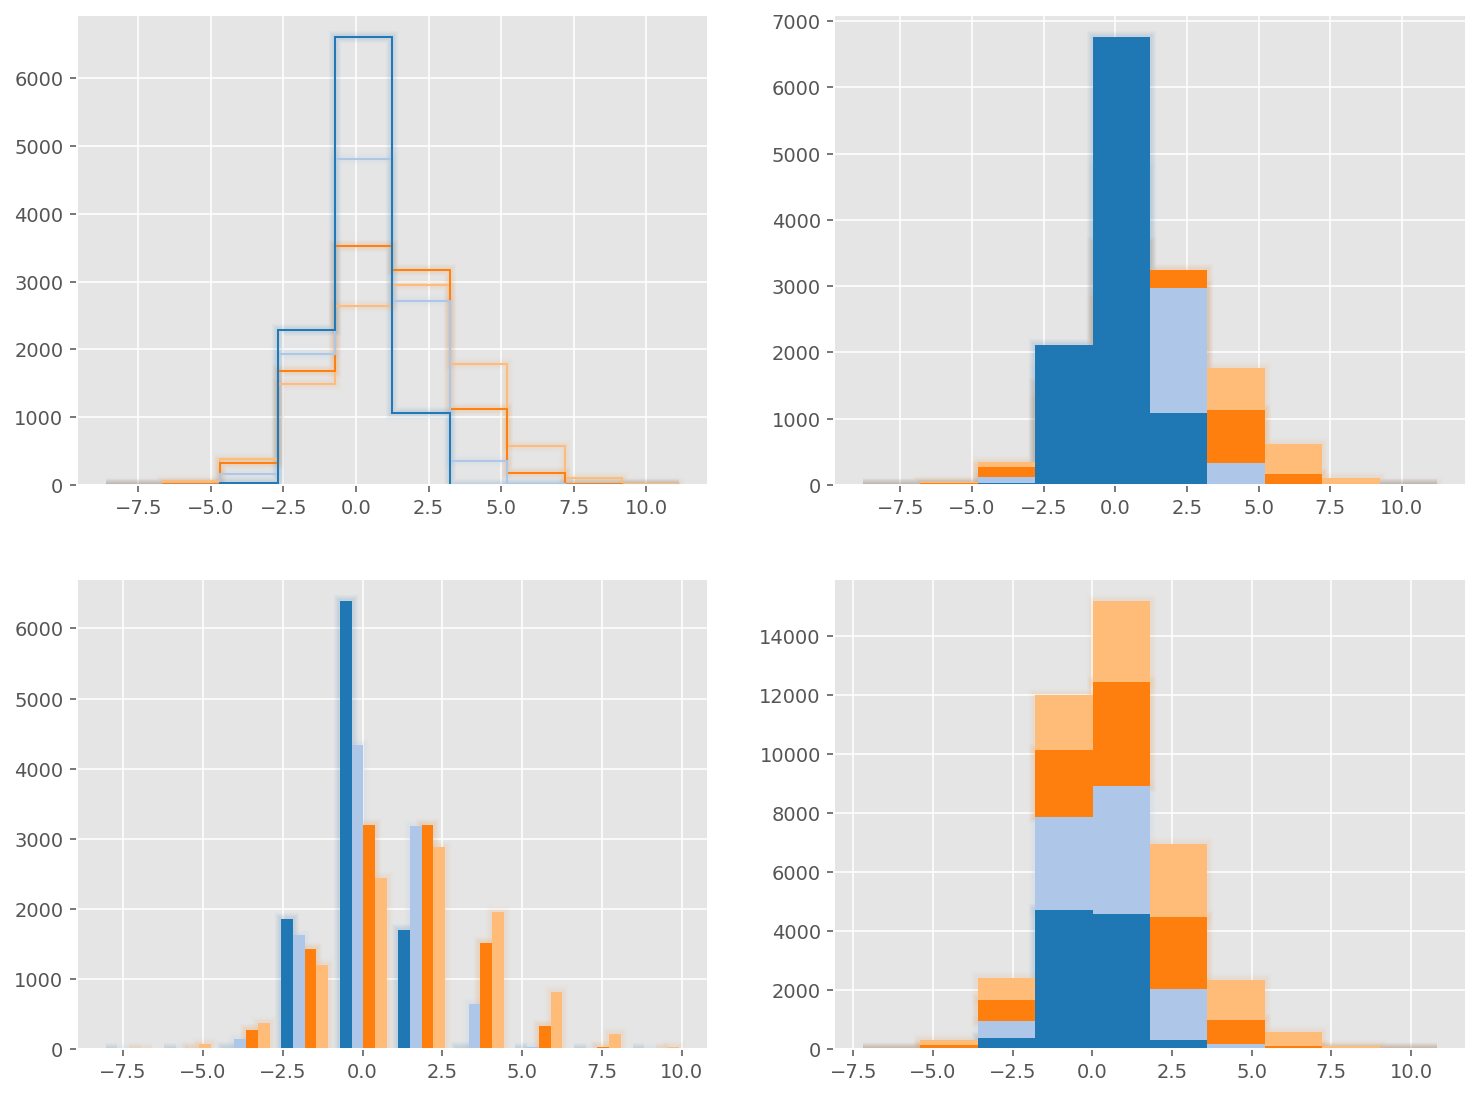

In [2]:
plt.subplots(2, 2, figsize = (6.4 * 2, 4.8 * 2))

mode = ["step", "stepfilled", "bar", "barstacked"]
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.hist(np.random.normal((0, 0.5, 1, 1.5), (1, 1.5, 2, 2.5), (10000, 4)), stacked = False, histtype = mode[i])
    hist_glow(n = 5)


# Event Selection

In [2]:
config = "work/2023/cex_analysis_1GeV_config.json"
args = cross_section.ApplicationArguments.ResolveConfig(cross_section.LoadConfiguration(config))
beam_quality_fits = {"mc" : args.mc_beam_quality_fit, "data" : args.data_beam_quality_fit}

with open(args.mc_beam_scraper_fit, "r") as file:
    beam_scraper_fits = json.load(file)

for f in beam_quality_fits:
    with open(beam_quality_fits[f], "r") as file:
        beam_quality_fits[f] = json.load(file)

mc = Master.Data(args.mc_file, nTuple_type = Master.Ntuple_Type.PDSP, nEvents = -1)
# data = Master.Data(args.data_file, nTuple_type = Master.Ntuple_Type.PDSP)

mask = BeamParticleSelection.CreateDefaultSelection(mc, beam_quality_fits = beam_quality_fits["mc"], return_table = False)
# mask = BeamParticleSelection.CreateDefaultSelection(mc, beam_quality_fits = beam_quality_fits["mc"], return_table = False, scraper = True, scraper_fits = beam_scraper_fits, scraper_cut = 1.4, scraper_KE_range = 1)
mc.Filter([mask], [mask])
 
mask = mc.trueParticles.pdg[:, 0] == 211 #! for this study only, select true pions

mc.Filter([mask], [mask])

# samples = {"mc" : mc, "data": data}

number of entries before|after PiBeamSelection: 298194|170238
number of entries before|after PandoraTagCut: 298194|245977
number of entries before|after CaloSizeCut: 298194|247361


/home/sb16165/anaconda3/envs/python3_10_0/lib/python3.10/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: divide by zero encountered in divide
  result = getattr(ufunc, method)(
/home/sb16165/anaconda3/envs/python3_10_0/lib/python3.10/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in divide
  result = getattr(ufunc, method)(


number of entries before|after MichelScoreCut: 298194|230193
number of entries before|after BeamQualityCut: 298194|176655
number of entries before|after APA3Cut: 298194|270725
number of entries before|after MedianDEdXCut: 298194|198023
                 number of events which pass the cut  single efficiency  \
no selection                                298194.0         100.000000   
PiBeamSelection                             170238.0          57.089680   
PandoraTagCut                               245977.0          82.488917   
CaloSizeCut                                 247361.0          82.953044   
MichelScoreCut                              230193.0          77.195718   
BeamQualityCut                              176655.0          59.241635   
APA3Cut                                     270725.0          90.788212   
MedianDEdXCut                               198023.0          66.407439   

                 number of events after successive cuts  \
no selection                 

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to filters.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to filename.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to nTuple_type.
  warnings.warn(f"Couldn't apply filters to {var}.")


In [68]:
save = True
if save: pdf = PdfPages("beam_KE_plots.pdf")
def Save():
    if save: pdf.savefig()

# $KE^{true}_{ff}$ and $KE^{reco}_{inst}$

In [69]:
ind = ak.argmax(mc.trueParticles.beam_traj_pos.z >= 0, -1, keepdims = True)
true_ffKE = ak.flatten(mc.trueParticles.beam_traj_KE[ind])

In [70]:
KE_inst = KE(mc.recoParticles.beam_inst_P, Particle.from_pdgid(211).mass)

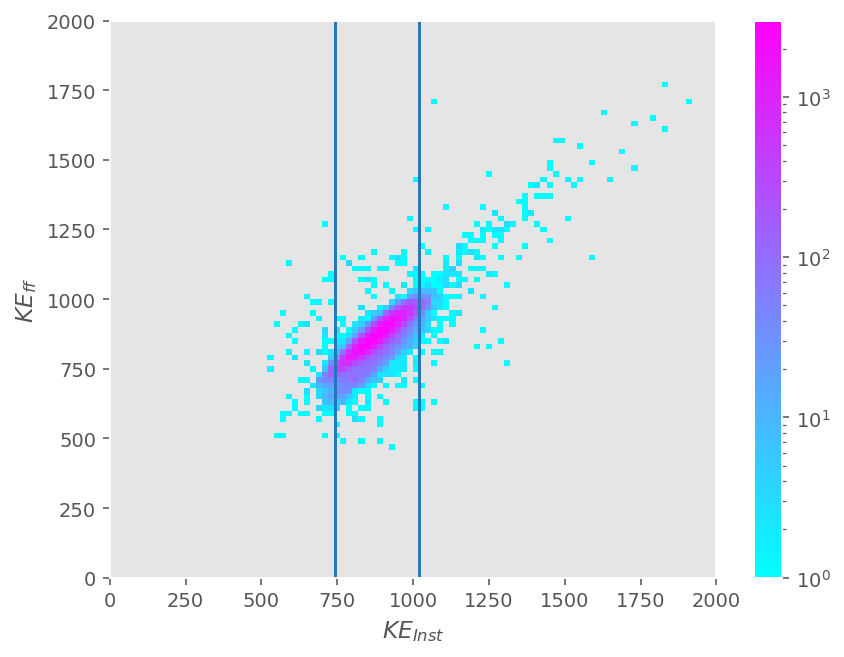

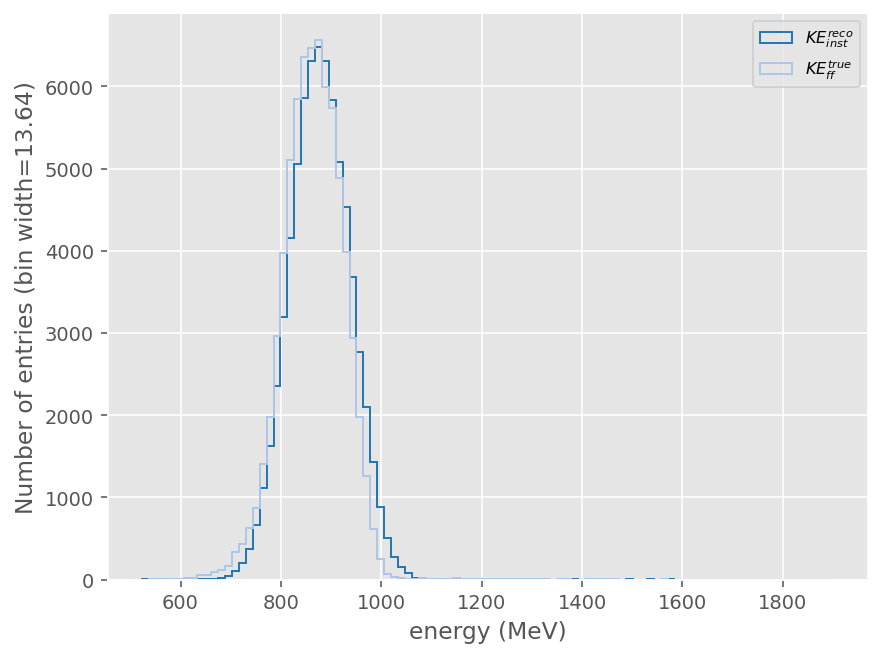

In [71]:
Plots.PlotHist2D(KE_inst[true_ffKE > 0], true_ffKE[true_ffKE > 0], cmap = "cool", xlabel = "$KE_{Inst}$", ylabel = "$KE_{ff}$", x_range = [0, 2000], y_range = [0, 2000])
plt.axvline(np.percentile(KE_inst, 99))
plt.axvline(np.percentile(KE_inst, 1))
Save()

Plots.PlotHistComparison([KE_inst, true_ffKE], labels = ["$KE^{reco}_{inst}$", "$KE^{true}_{ff}$"], xlabel = "energy (MeV)", density = False, xRange = [0, 2000])
Save()

# Upstream Energy loss ($\Delta E_{loss}$)

In [72]:
class poly2d(Fitting.FitFunction):
    n_params = 3

    @staticmethod
    def func(x, a, b, c):
        return a + (b * x) + c * (x**2)

    @staticmethod
    def p0(x, y):
        return None

    @staticmethod
    def bounds(x, y):
        return ([min(y), -np.inf, -np.inf], [np.inf]*3)

### Fit using arithmetic mean as central value in each bin

[944, 5681, 16242, 22861, 17052, 7021, 1298, 101]

[ 3.87482054e+02 -9.74168052e-01  6.22866976e-04]

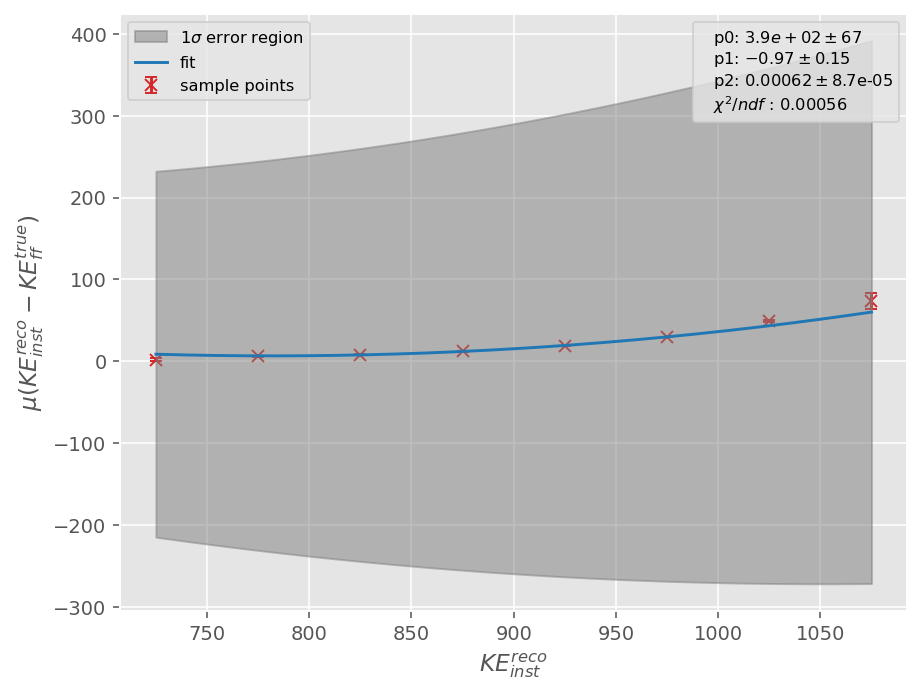

In [73]:
# bins = ak.Array([np.percentile(KE_inst, 1), 1650, 1750, 1850, 1950, 2050, 2150, np.percentile(KE_inst, 99)])
bins = ak.Array([700, 750, 800, 850, 900, 950, 1000, 1050, 1100])

binned_data = {"KE_inst": [], "KEff_true" : [], "KE_first_true" : []}
for i in range(len(bins)-1):
    mask = (KE_inst > bins[i]) & (KE_inst < bins[i + 1])
    mask = mask & (true_ffKE > 0)

    binned_data["KE_inst"].append( KE_inst[mask] )
    binned_data["KEff_true"].append( true_ffKE[mask] )
binned_data = {i : ak.Array(binned_data[i]) for i in binned_data}

print(ak.num(binned_data["KE_inst"]))
residual_energy = binned_data["KE_inst"] - binned_data["KEff_true"]

mean_residual_energy = ak.mean(residual_energy, axis = -1)
mean_error_residual_energy = ak.std(residual_energy, axis = -1) / np.sqrt(ak.num(residual_energy))

x = (bins[1:] + bins[:-1]) / 2
xerr = abs(x - bins[1:])

plt.figure()
popt, perr = Fitting.Fit(x, mean_residual_energy, mean_error_residual_energy, poly2d, plot = True)
plt.xlabel("$KE^{reco}_{inst}$")
plt.ylabel("$\mu(KE^{reco}_{inst} - KE^{true}_{ff})$")
print(popt)


### Fit using central value determined by fits 

KE_inst   true_ffKE   residual
0      773.444544  790.840367 -17.395823
1      964.471504  923.967734  40.503769
2      825.480091  798.058894  27.421197
3      888.239037  841.598619  46.640418
4      814.389800  836.152411 -21.762611
...           ...         ...        ...
71449  955.707315  910.508618  45.198697
71450  914.403921  926.720830 -12.316909
71451  854.234647  814.686840  39.547807
71452  862.575795  849.472264  13.103531
71453  858.226303  843.781870  14.444432

[71454 rows x 3 columns]

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Fitting.py:180: RuntimeWarning: invalid value encountered in power
  y = np.where(t > -alpha, np.exp(-t**2 / 2), A * (B - t)**-n)


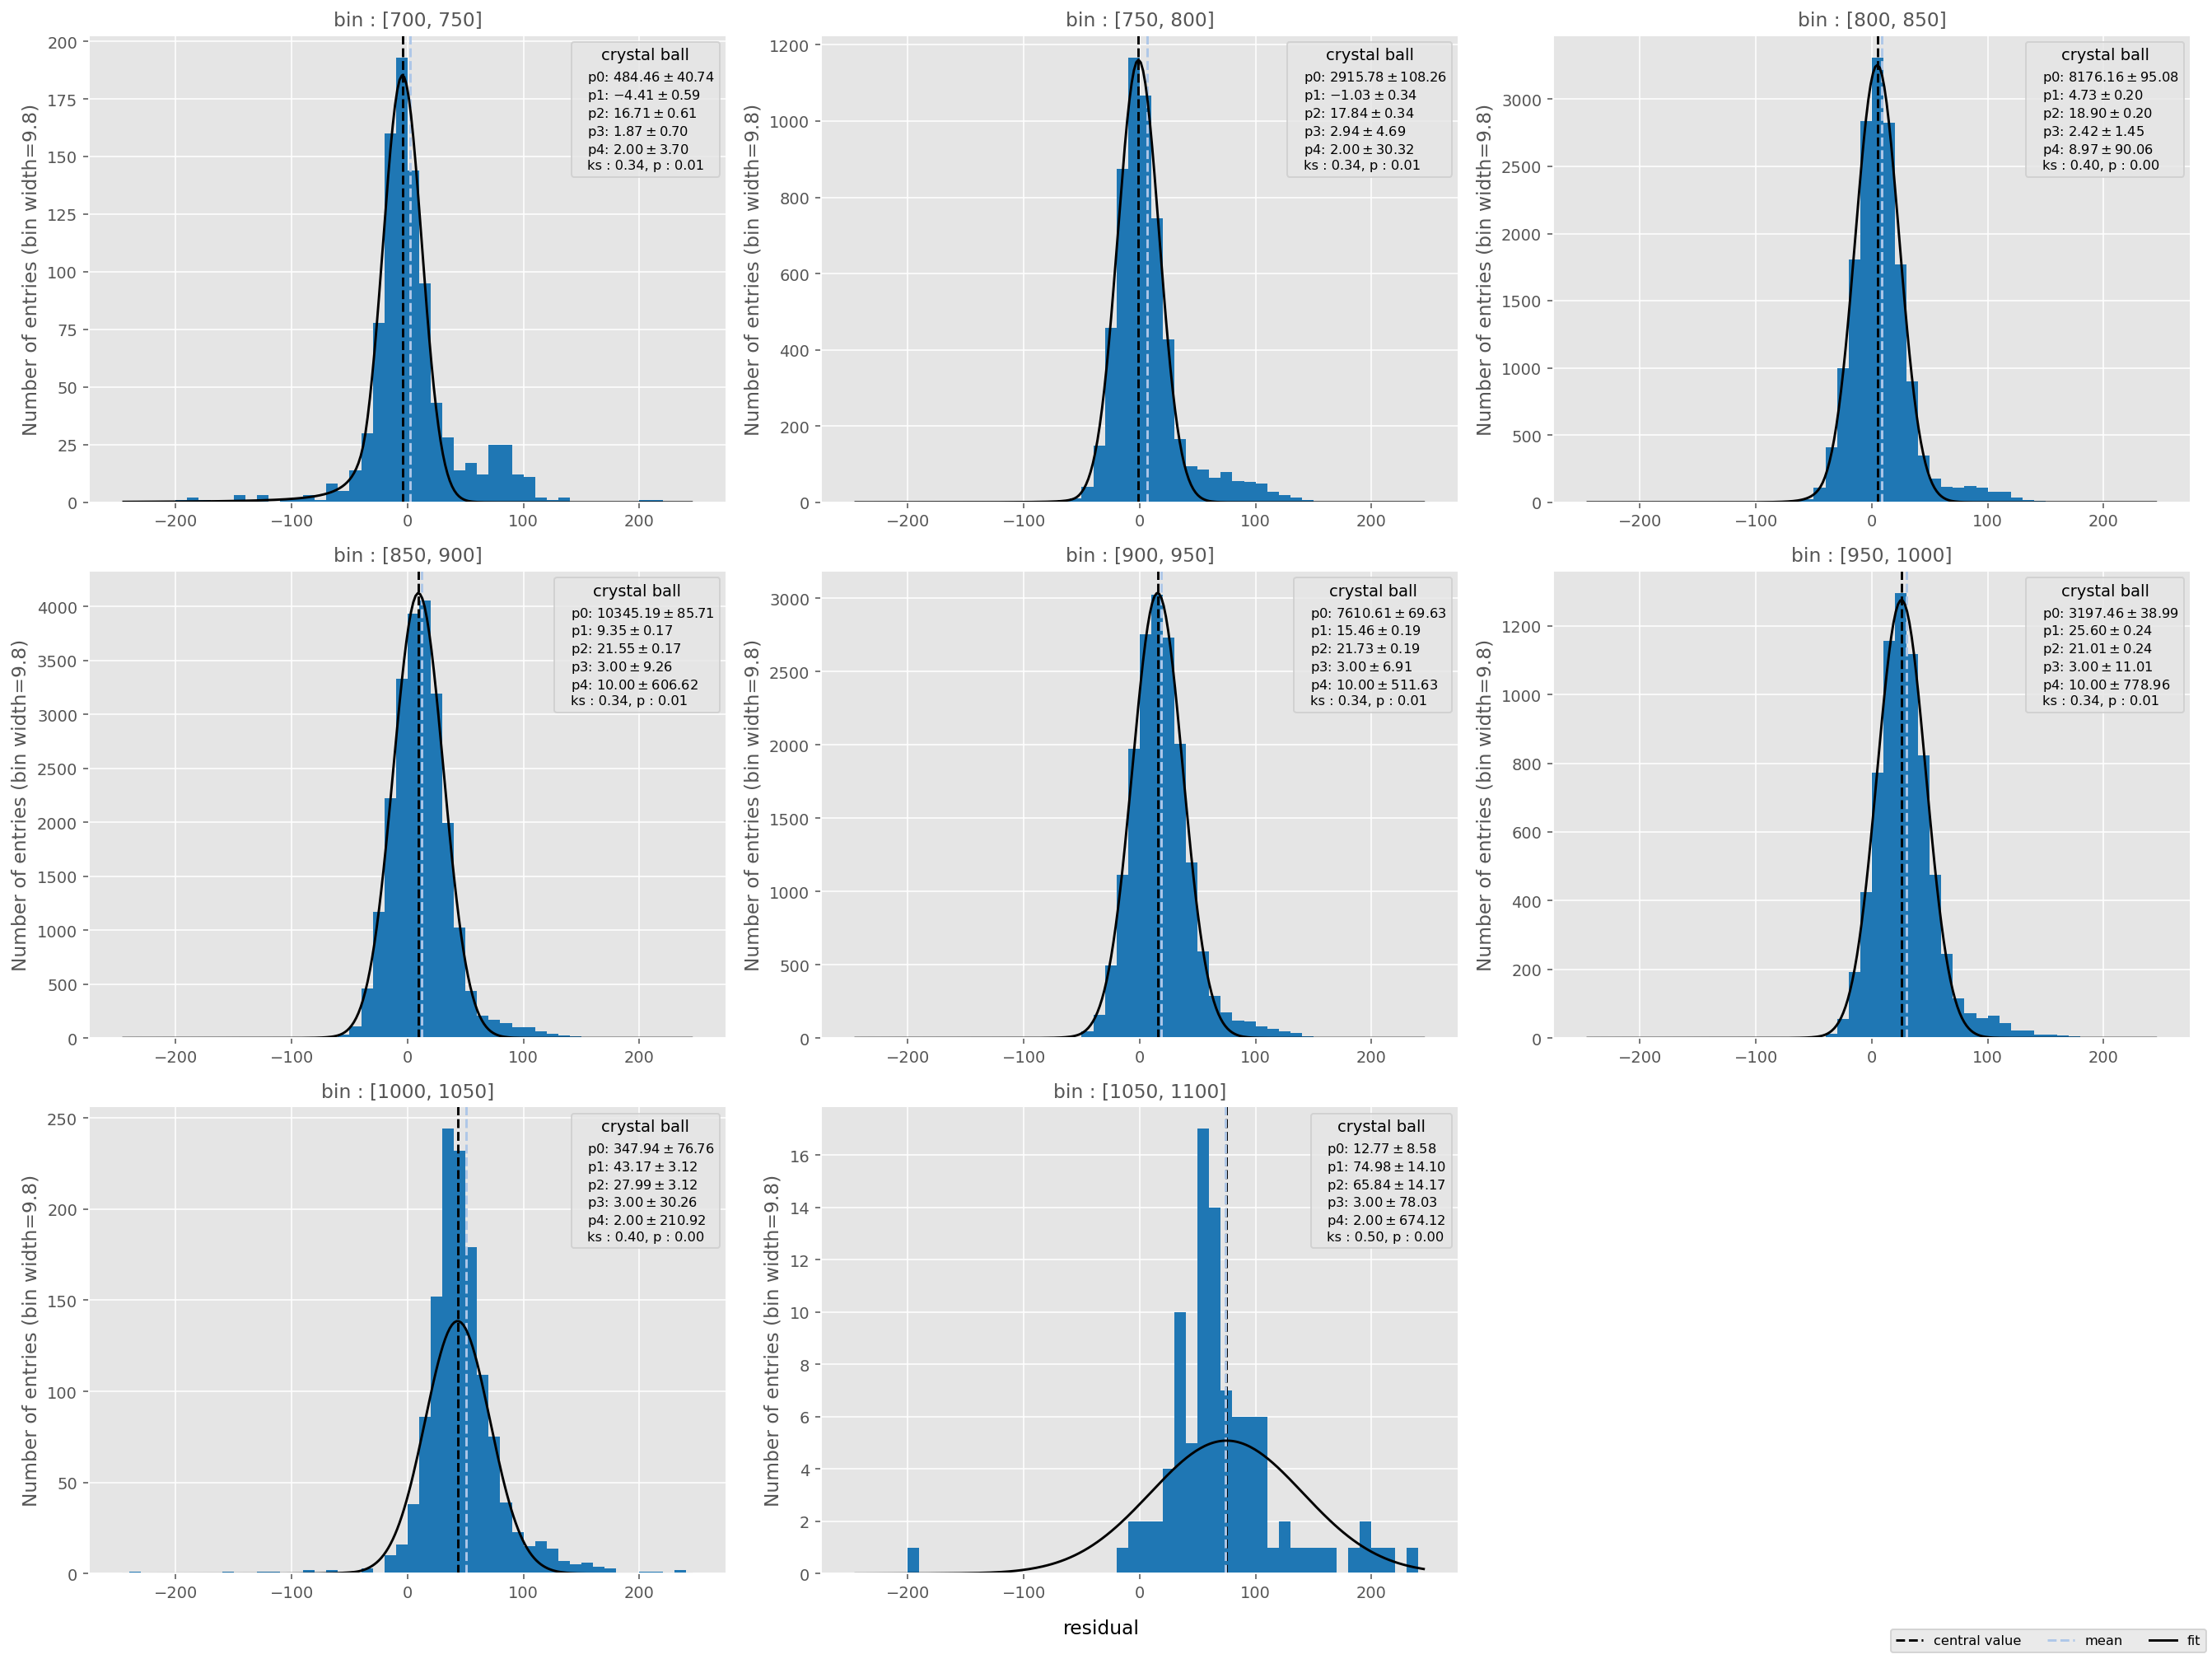

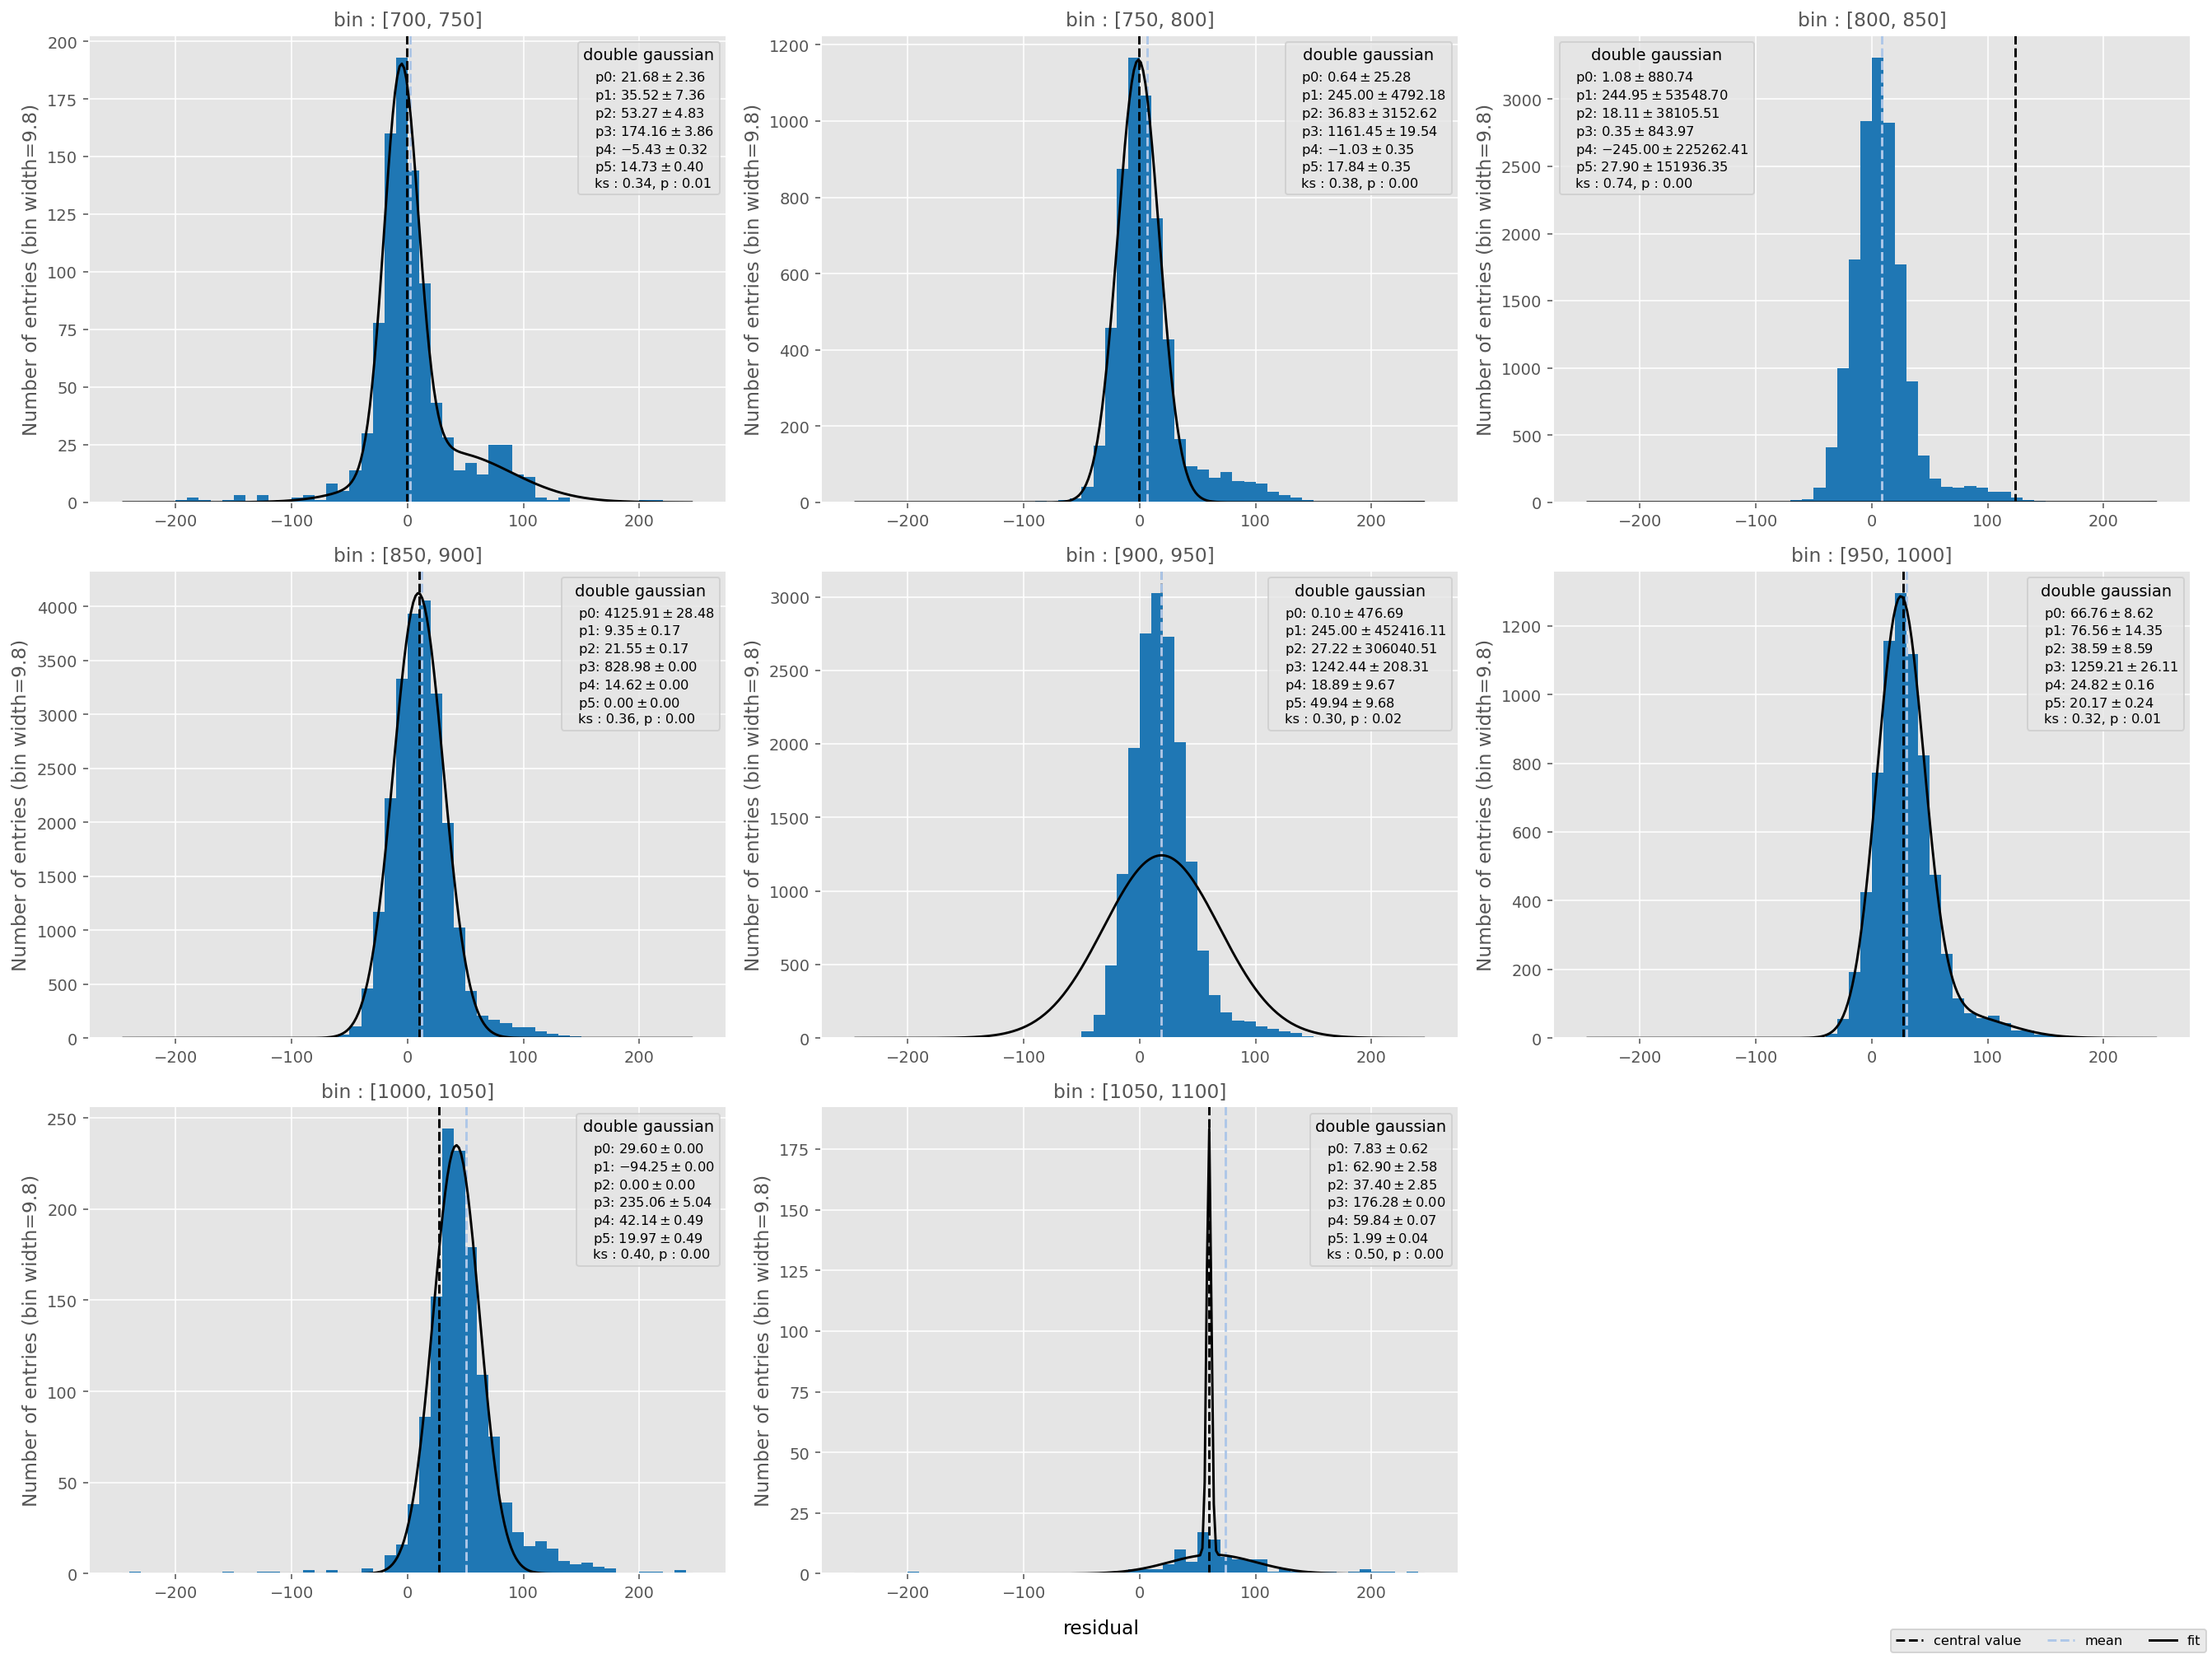

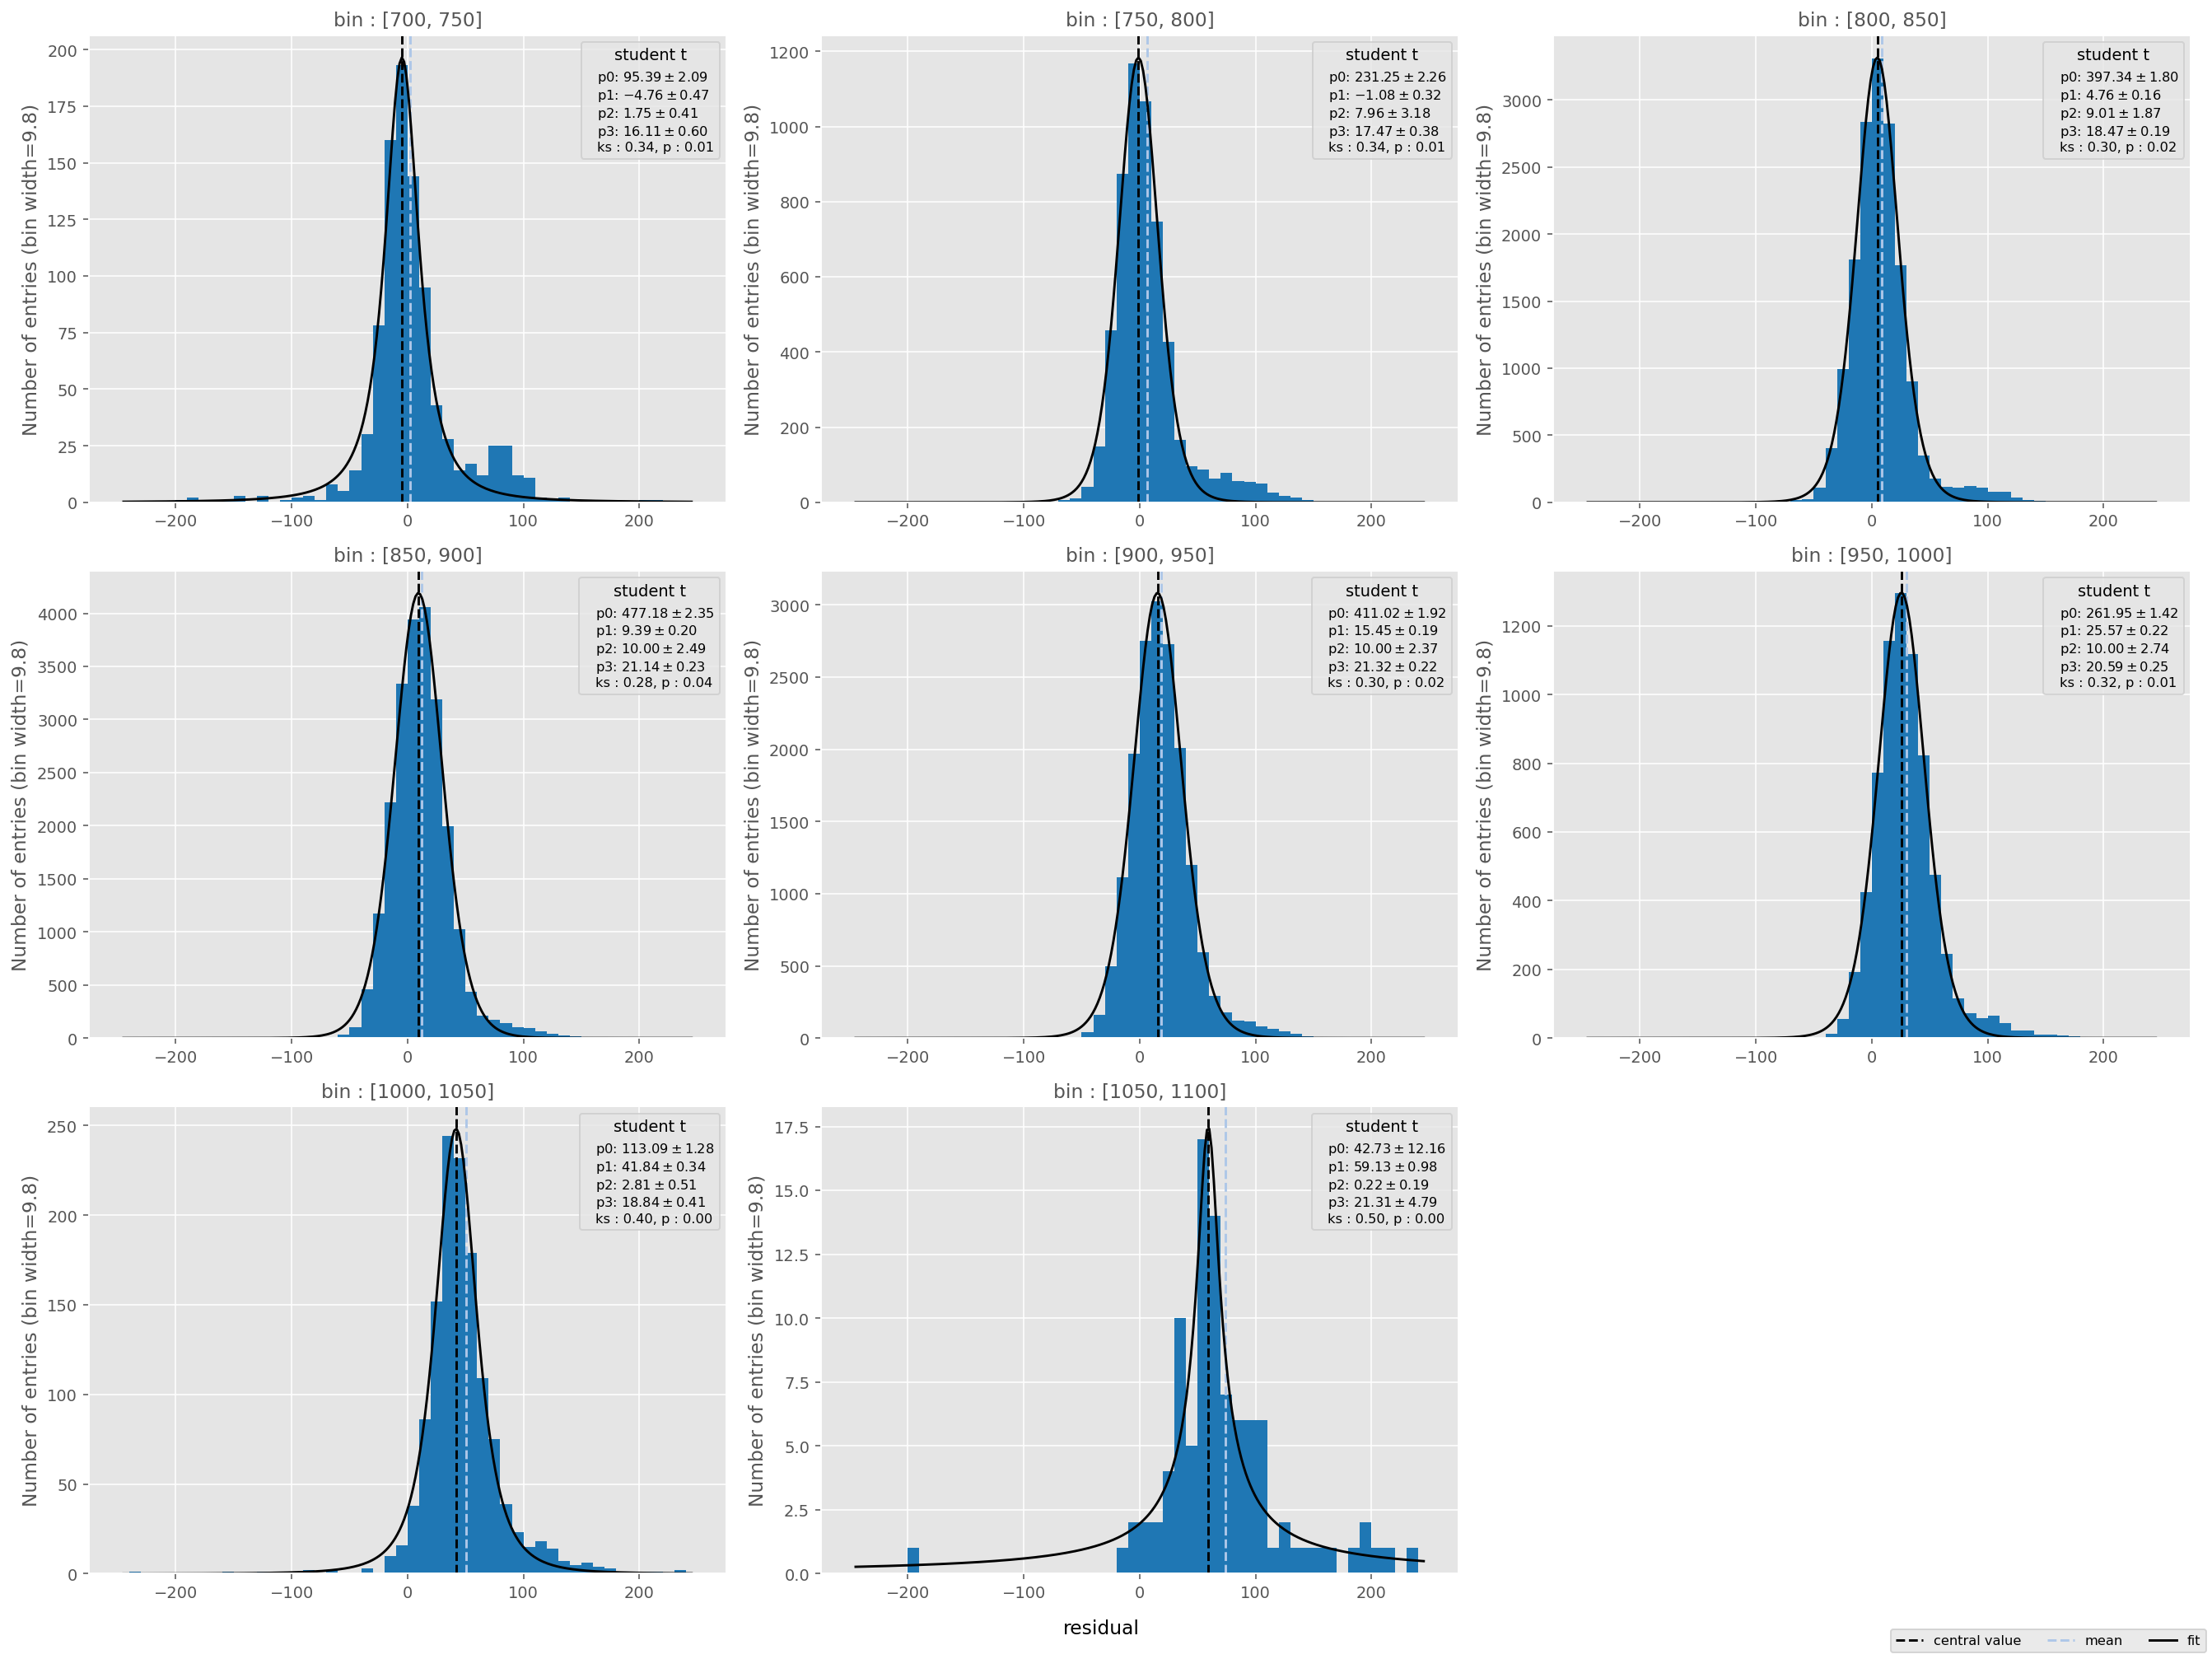

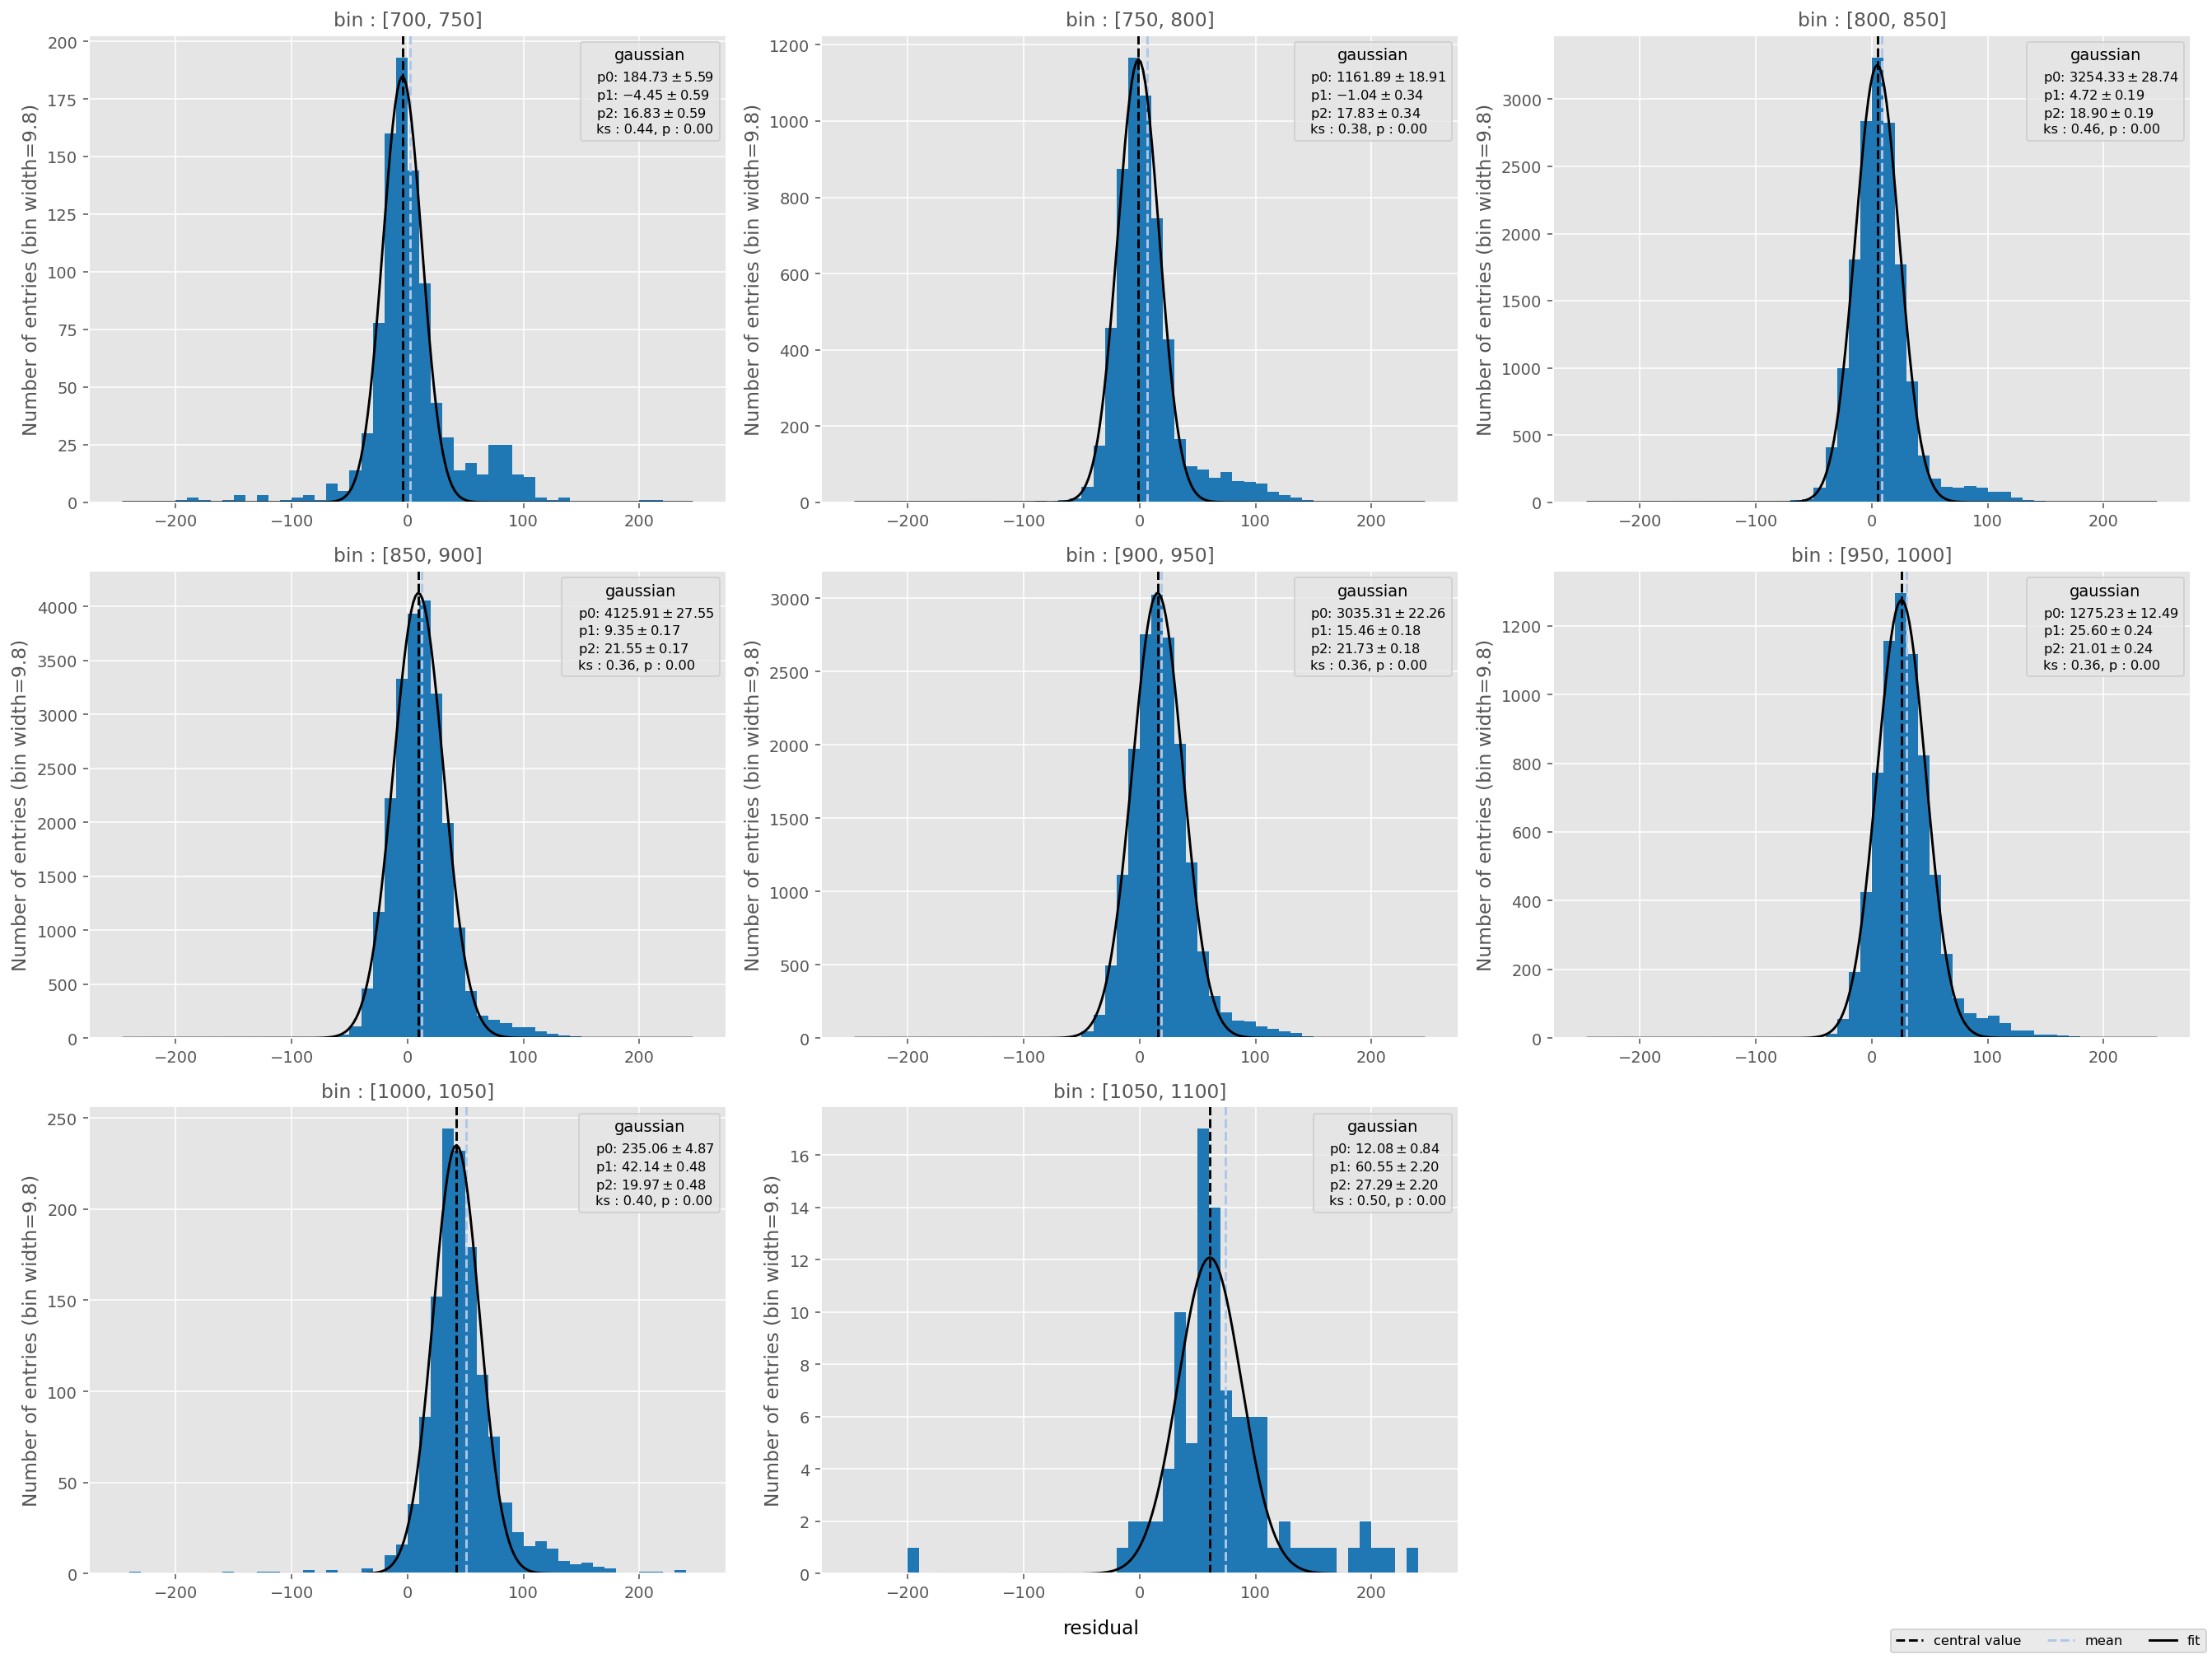

In [74]:
df = pd.DataFrame({"KE_inst" : KE_inst, "true_ffKE" : true_ffKE})
df["residual"] = df.KE_inst - df.true_ffKE
print(df)

# bins = np.array(Fitting.create_bins_df(df.KE_inst, 500, [700, 1050]), dtype = int)

functions = {
    "crystal_ball" : Fitting.crystal_ball,
    "double_gaussian" : Fitting.double_gaussian,
    "student_t" : Fitting.student_t,
    "gaussian" : Fitting.gaussian
}

bins = ak.Array([700, 750, 800, 850, 900, 950, 1000, 1050, 1100])
central_values = {}

for f in functions:
    cv = Fitting.ExtractCentralValues_df(df, "KE_inst", "residual", [-250, 250], [functions[f]], bins, 50, rms_err = False)
    central_values[f] = {"value" : cv[0], "error" : cv[1]}
    Save()


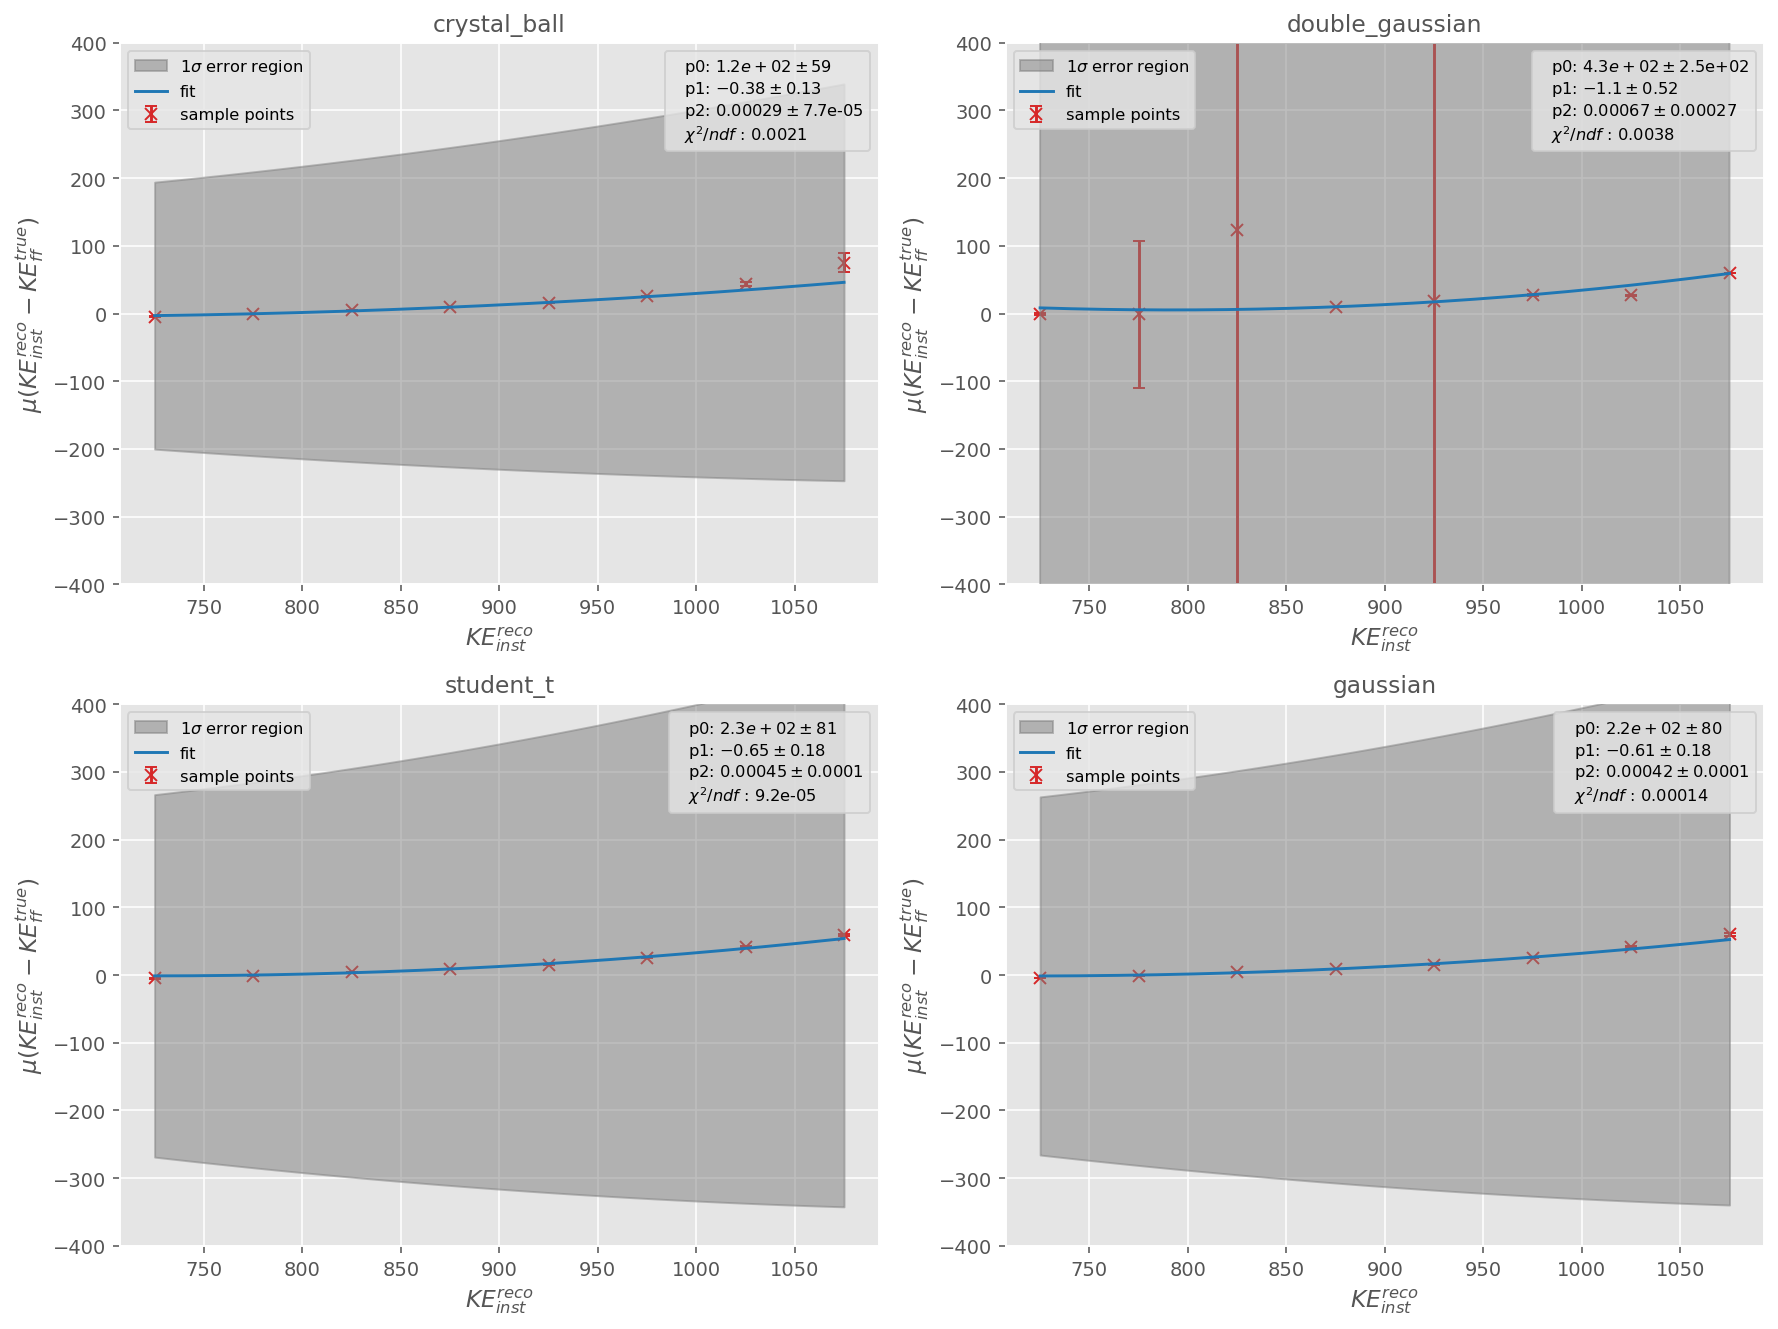

In [75]:
class line(Fitting.FitFunction):
    def func(x, m, c):
        return m*x + c

    def bounds(x, y):
        return (-np.inf, np.inf)

    def p0(x, y):
        return None


x = (bins[1:] + bins[:-1]) / 2
xerr = abs(x - bins[1:])

popt = {}
perr = {}
for i, cv in Plots.IterMultiPlot(central_values, True, True):
    params = Fitting.Fit(x, central_values[cv]["value"], central_values[cv]["error"], poly2d, plot = True, xlabel = "$KE^{reco}_{inst}$", ylabel = "$\mu(KE^{reco}_{inst} - KE^{true}_{ff})$", maxfev = int(5E5), ylim = [-400, 400])
    plt.title(cv)
    popt[cv] = params[0]
    perr[cv] = params[1]
Save()


['p0 : 2.2e+02 \\pm 80', 'p1 : -0.61 \\pm 0.18', 'p2 : 0.00042 \\pm 0.0001']

['p0 : 2.2e+02 \\pm 43', 'p1 : -0.63 \\pm 0.1', 'p2 : 0.00045 \\pm 6.3e-05']

['p0 : 1.7e+02 \\pm 13', 'p1 : -0.57 \\pm 0.03', 'p2 : 0.00043 \\pm 1.7e-05']

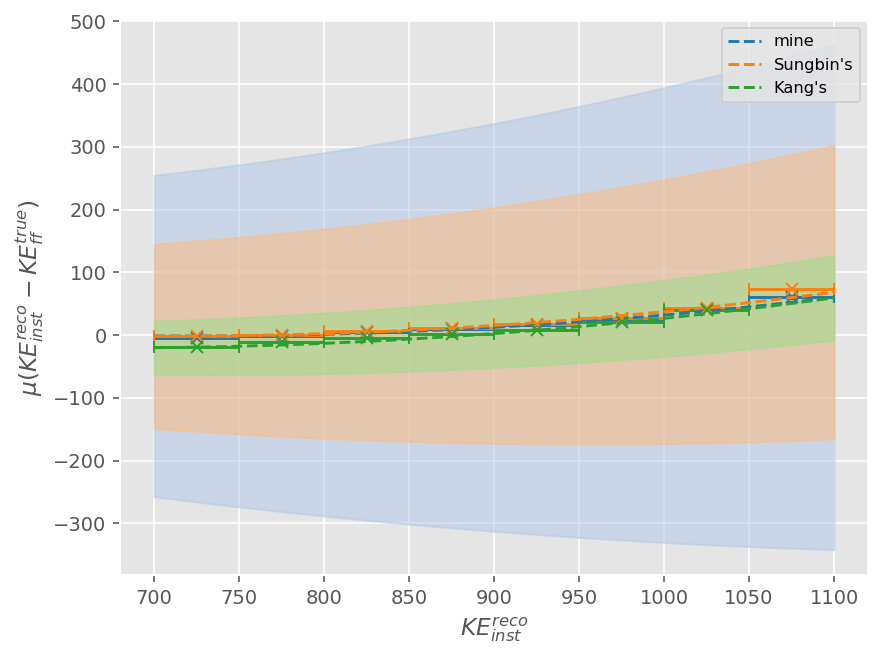

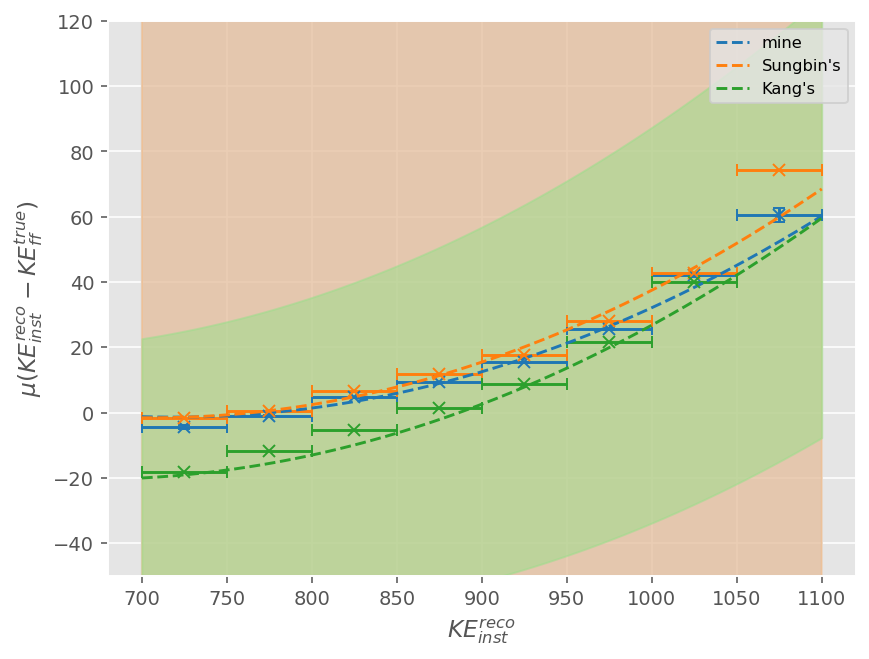

In [76]:
x_interp = np.linspace(700, 1100, 1000)

# Sungbin's correction parameters
s_popt = np.array([2.223e+02, -6.348e-01, 4.500e-04])
s_err = np.array([4.31e+01, 1.04e-01, 6.33e-05])

s_x = [725, 775, 825, 875, 925, 975, 1025, 1075]
s_y = [-1.5209125475285177, 0.5323193916349815, 6.692015209125476, 11.711026615969583, 17.642585551330797, 28.136882129277566, 42.737642585551335, 74.22053231939164]

# Kangs's correction parameters
k_popt = np.array([171.8, -0.575, 4.3e-4])
k_err = np.array([13.1, 0.03, 1.75e-5])

k_x = [725, 775, 825, 875, 925, 975, 1025]
k_y = [-18.21656050955414, -11.59235668789809, -5.222929936305732, 1.4012738853503173, 8.789808917197451, 21.783439490445858, 39.87261146496815]

xl = "$KE^{reco}_{inst}$"
yl = "$\mu(KE^{reco}_{inst} - KE^{true}_{ff})$"

for v, e in zip([popt["gaussian"], s_popt, k_popt], [perr["gaussian"], s_err, k_err]):
    print([f"p{i} : {v[i]:.2g} \pm {e[i]:.2g}" for i in range(len(v))])

def upstream_loss_fit():
    Plots.Plot(x, central_values["gaussian"]["value"], yerr = central_values["gaussian"]["error"], xerr = 25, marker = "x", linestyle = "", xlabel = xl, ylabel = yl)
    Plots.Plot(x_interp, poly2d.func(x_interp, *popt["gaussian"]), newFigure = False, color = "C0", linestyle = "--", label = f'mine')
    plt.fill_between(x_interp, poly2d.func(x_interp, *(popt["gaussian"] - perr["gaussian"])), poly2d.func(x_interp, *(popt["gaussian"] + perr["gaussian"])), alpha = 0.5, color = "C1")

    Plots.Plot(s_x, s_y, xerr = 25, marker = "x", linestyle = "", color = "C2", newFigure = False)
    Plots.Plot(x_interp, poly2d.func(x_interp, *s_popt), newFigure = False, color = "C2", linestyle = "--", label = f"Sungbin's")
    plt.fill_between(x_interp, poly2d.func(x_interp, *(s_popt - s_err)), poly2d.func(x_interp, *(s_popt + s_err)), alpha = 0.5, color = "C3")

    Plots.Plot(k_x, k_y, xerr = 25, marker = "x", linestyle = "", color = "C4", newFigure = False)
    Plots.Plot(x_interp, poly2d.func(x_interp, *k_popt), newFigure = False, color = "C4", linestyle = "--", label = f"Kang's")
    plt.fill_between(x_interp, poly2d.func(x_interp, *(k_popt - k_err)), poly2d.func(x_interp, *(k_popt + k_err)), alpha = 0.5, color = "C5")

    plt.legend()
    return

upstream_loss_fit()
Save()

upstream_loss_fit()
plt.ylim(-50, 120)
Save()

### Comparison

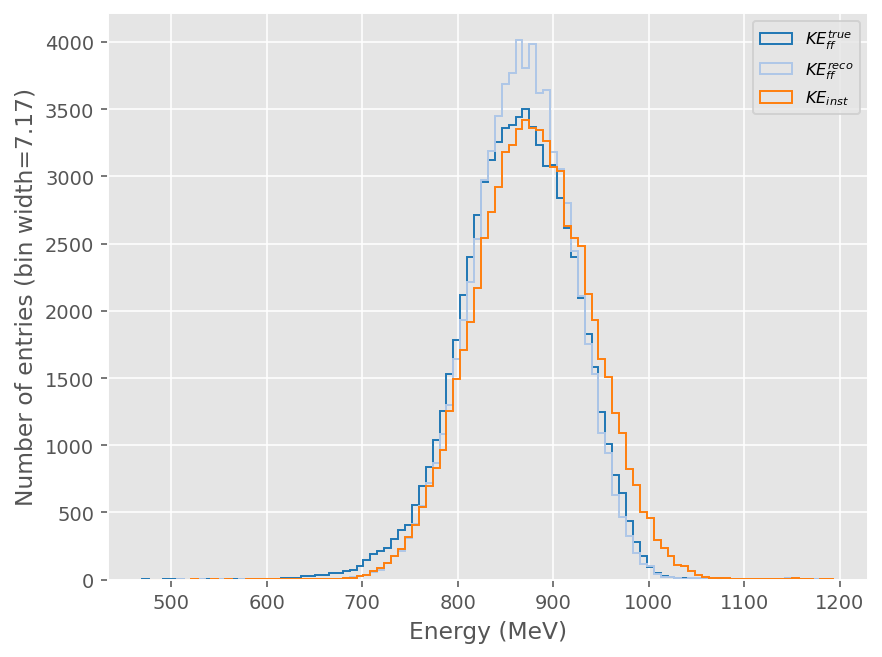

In [77]:
reco_ffKE = KE_inst - poly2d.func(KE_inst, *popt["gaussian"])
Plots.PlotHistComparison([true_ffKE, reco_ffKE, KE_inst], labels = ["$KE^{true}_{ff}$", "$KE^{reco}_{ff}$", "$KE_{inst}$"], xlabel = "Energy (MeV)", xRange = [0, 1200], density = False)
Save()


# Energy loss in TPC

### $\Delta E^{reco}_{calo}$

In [78]:
reco_pitch = vector.dist(mc.recoParticles.beam_calo_pos[:, :-1], mc.recoParticles.beam_calo_pos[:, 1:]) # distance between reconstructed calorimetry points
dE = ak.sum(mc.recoParticles.beam_dEdX[:, :-1] * reco_pitch, -1)

(array([ 779.,  955., 1445., 1960., 2230., 2296., 2319., 2307., 2272.,
        2128., 2127., 2115., 1957., 1819., 1898., 1810., 1738., 1624.,
        1646., 1548., 1473., 1343., 1364., 1252., 1167., 1137., 1106.,
        1029., 1047.,  983.,  934.,  954.,  874.,  843.,  813.,  738.,
         795.,  741.,  676.,  684.,  704.,  633.,  635.,  581.,  572.,
         524.,  475.,  390.,  350.,  321.,  294.,  226.,  217.,  196.,
         180.,  177.,  160.,  149.,  126.,  140.,  137.,  108.,  113.,
          97.,  106.,   90.,   94.,   83.,   65.,   72.,   70.,   73.,
          58.,   61.,   61.,   60.,   47.,   56.,   55.,   46.,   67.,
          46.,   47.,   50.,   35.,   50.,   45.,   49.,   25.,   46.,
          41.,   38.,   38.,   29.,   36.,   33.,   31.,   33.,   26.,
          33.]),
 array([   0.,   10.,   20.,   30.,   40.,   50.,   60.,   70.,   80.,
          90.,  100.,  110.,  120.,  130.,  140.,  150.,  160.,  170.,
         180.,  190.,  200.,  210.,  220.,  230.,  240.,  25

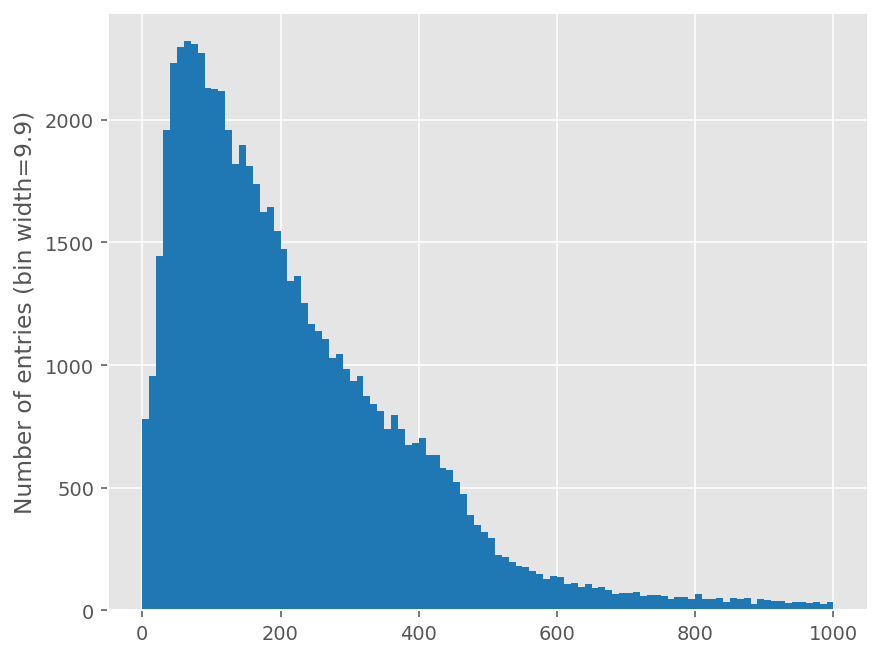

In [79]:
Plots.PlotHist(ak.ravel(dE), range = [0, 1000])

### $\Delta E^{reco}_{bb}$

In [80]:
reco_pitch_padded = ak.fill_none(ak.pad_none(reco_pitch, max(ak.num(reco_pitch)), -1), 0) # pad so all beam particles have the same number ov pitches (padded values are set to zero)
KE_int_bb = reco_ffKE
for d in range(max(ak.num(reco_pitch_padded))): # loop through all trajectoty points and compute dEdX simultaneously for all particles
    KE_int_bb = KE_int_bb - reco_pitch_padded[:, d] * cross_section.BetheBloch.meandEdX(KE_int_bb, Particle.from_pdgid(211))


/home/sb16165/anaconda3/envs/python3_10_0/lib/python3.10/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(
/home/sb16165/anaconda3/envs/python3_10_0/lib/python3.10/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in power
  result = getattr(ufunc, method)(


(array([7.890e+02, 1.005e+03, 1.445e+03, 2.205e+03, 2.571e+03, 2.653e+03,
        2.700e+03, 2.535e+03, 2.537e+03, 2.559e+03, 2.488e+03, 2.377e+03,
        2.421e+03, 2.235e+03, 2.124e+03, 2.101e+03, 1.958e+03, 1.969e+03,
        1.847e+03, 1.749e+03, 1.606e+03, 1.615e+03, 1.529e+03, 1.431e+03,
        1.386e+03, 1.251e+03, 1.237e+03, 1.199e+03, 1.149e+03, 1.048e+03,
        1.000e+03, 9.910e+02, 9.180e+02, 9.180e+02, 8.880e+02, 8.290e+02,
        7.870e+02, 7.430e+02, 7.050e+02, 6.990e+02, 6.530e+02, 6.800e+02,
        5.730e+02, 6.110e+02, 5.590e+02, 5.360e+02, 4.880e+02, 5.170e+02,
        4.650e+02, 4.910e+02, 4.160e+02, 4.130e+02, 3.680e+02, 2.370e+02,
        1.170e+02, 6.200e+01, 3.700e+01, 1.200e+01, 5.000e+00, 4.000e+00,
        3.000e+00, 4.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+0

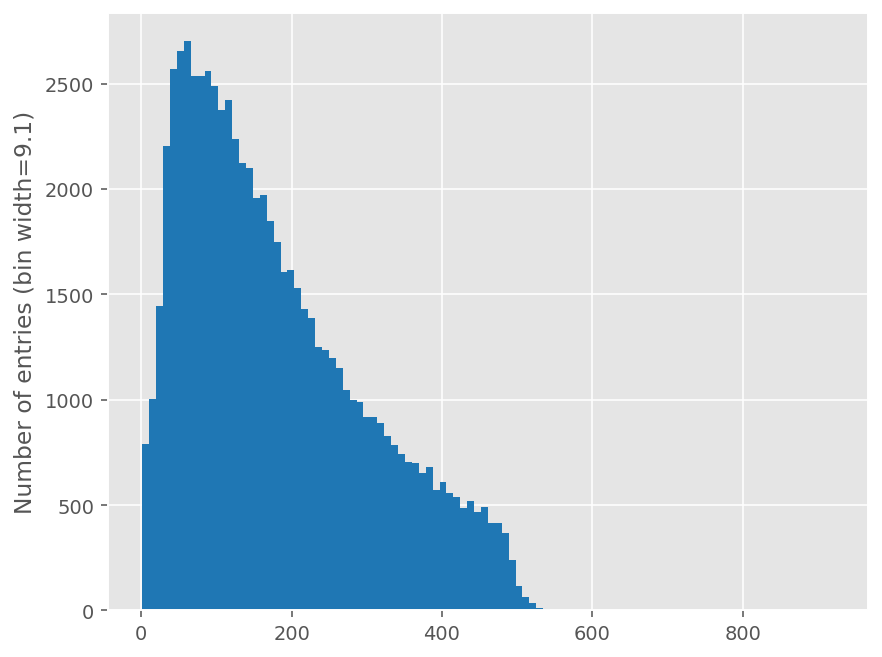

In [81]:
dE_bb = reco_ffKE - KE_int_bb
Plots.PlotHist(dE_bb)

### Comparison to truth ($\Delta E^{true}$)

In [82]:
dE_true = true_ffKE - mc.trueParticles.beam_traj_KE[:, -2]

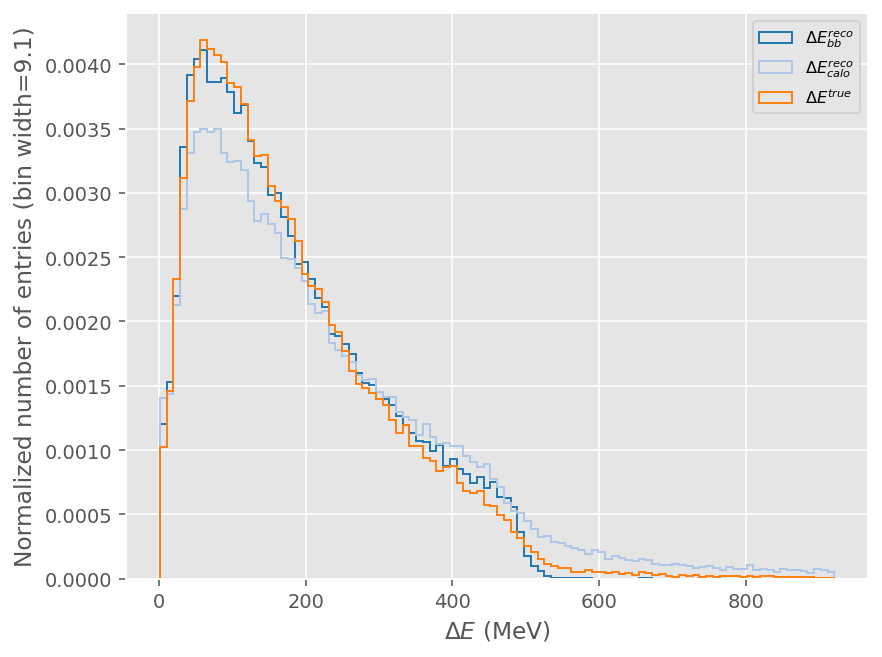

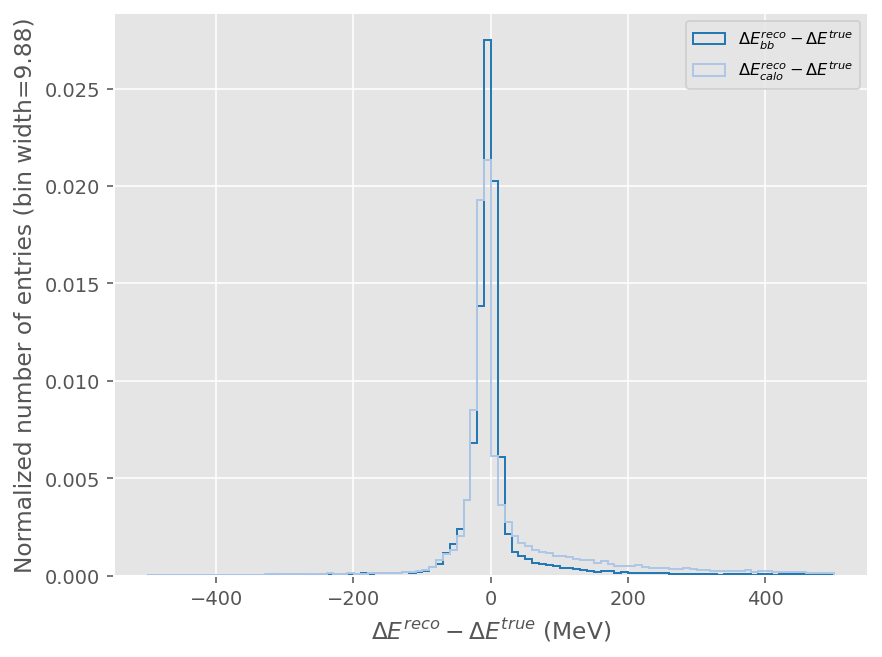

In [83]:
labels = ["$\Delta E^{reco}_{bb}$", "$\Delta E^{reco}_{calo}$", "$\Delta E^{true}$"]
Plots.PlotHistComparison([dE_bb, dE, dE_true], labels = labels, xlabel = "$\Delta E$ (MeV)")
Save()
Plots.PlotHistComparison([dE_bb - dE_true, dE - dE_true], labels = [labels[0][:-1] + "-" + labels[2][1:], labels[1][:-1] + "-" + labels[2][1:]], xRange = [-500, 500], xlabel = "$\Delta E^{reco} - \Delta E^{true}$ (MeV)")
Save()

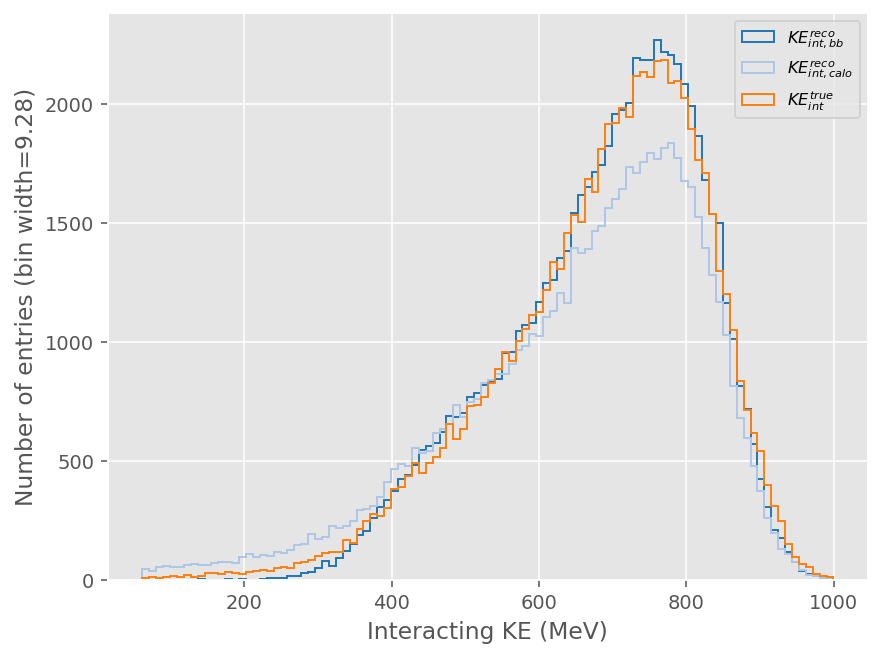

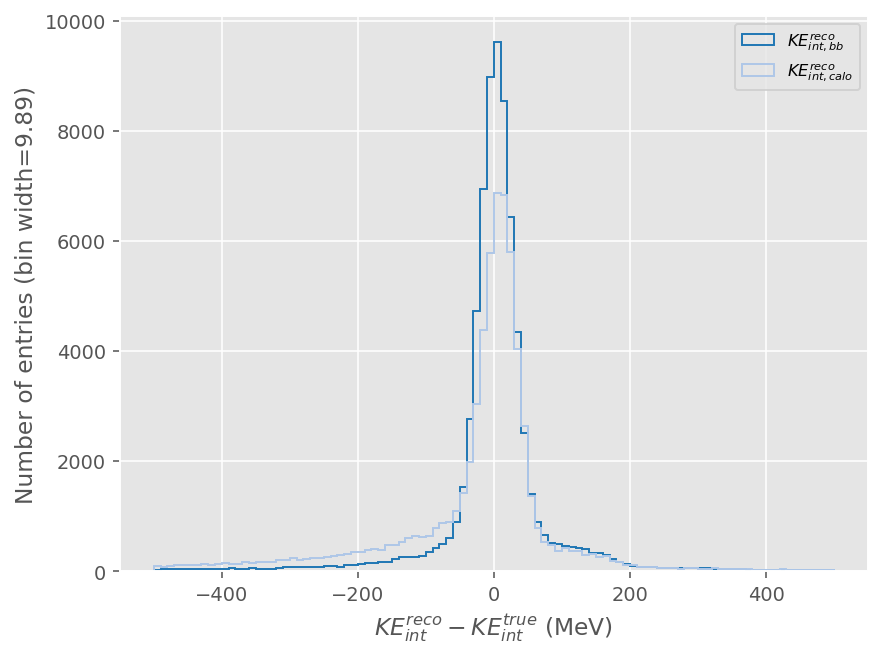

In [84]:
labels = ["$KE^{reco}_{int, bb}$", "$KE^{reco}_{int, calo}$", "$KE^{true}_{int}$"]
Plots.PlotHistComparison([reco_ffKE - dE_bb, reco_ffKE - dE, mc.trueParticles.beam_traj_KE[:, -2]], labels = labels, xlabel = "Interacting KE (MeV)", xRange = [0, 1000], density = False)
Save()
Plots.PlotHistComparison([reco_ffKE - dE_bb - mc.trueParticles.beam_traj_KE[:, -2], reco_ffKE - dE - mc.trueParticles.beam_traj_KE[:, -2]], labels = [labels[0], labels[1]], xRange = [-500, 500], xlabel = "$KE^{reco}_{int} - KE^{true}_{int}$ (MeV)", density = False)
Save()

In [85]:
pdf.close()